# Jianjin008 Training

In [34]:
!apt-get -qq install pv

In [35]:
from google.colab import drive
from google.colab import files
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import time, torch
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import ReduceLROnPlateau
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import os, json
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms as transforms

In [36]:
####### Inbal's account #######
drive.mount('/content/drive')

# Install pv for progress visualization

DATASET_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008"
REF_PATH = os.path.join(DATASET_PATH, "ref_img")
DIST_PATH = os.path.join(DATASET_PATH, "jnd_img")
MOS_FILE = os.path.join(DATASET_PATH, "mos.txt")
PATCHES_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008_patches"

print(f"DATASET_PATH defined as: {DATASET_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET_PATH defined as: /content/drive/MyDrive/Samsung_Project/jianjin008


In [37]:
####### Other accounts #######
drive.mount('/content/drive')

# Install pv for progress visualization

DATASET_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008"
REF_PATH = os.path.join(DATASET_PATH, "ref_img")
DIST_PATH = os.path.join(DATASET_PATH, "jnd_img")
MOS_FILE = os.path.join(DATASET_PATH, "mos.txt")
PATCHES_PATH = "/content/drive/MyDrive//Samsung_Project/jianjin008_patches"

print(f"DATASET_PATH defined as: {DATASET_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET_PATH defined as: /content/drive/MyDrive/Samsung_Project/jianjin008


In [38]:
# Sanity check on dataset and patches

# Check if the dataset directory exists and contains files
if os.path.exists(DATASET_PATH) and os.listdir(DATASET_PATH):
    print(f"Dataset directory '{DATASET_PATH}' exists and contains files.")
else:
    print(f"Error: Dataset directory '{DATASET_PATH}' not found or empty.")

# Check if reference and distorted image directories exist and contain files
if os.path.exists(REF_PATH) and os.listdir(REF_PATH):
    print(f"Reference images directory '{REF_PATH}' exists and contains files.")
else:
    print(f"Error: Reference images directory '{REF_PATH}' not found or empty.")

if os.path.exists(DIST_PATH) and os.listdir(DIST_PATH):
    print(f"Distorted images directory '{DIST_PATH}' exists and contains files.")
else:
    print(f"Error: Distorted images directory '{DIST_PATH}' not found or empty.")

# Check if MOS file exists
if os.path.exists(MOS_FILE):
    print(f"MOS file '{MOS_FILE}' found.")
else:
    print(f"Error: MOS file '{MOS_FILE}' not found.")

# Check if patches directory exists (it will be created later, so this is just a check)
if os.path.exists(PATCHES_PATH):
    print(f"Patches directory '{PATCHES_PATH}' exists.")
else:
    print(f"Patches directory '{PATCHES_PATH}' does not exist")

# Optional: Display a few image file names to confirm data is there
if os.path.exists(REF_PATH) and os.listdir(REF_PATH):
    print("\nSample reference image files:")
    print(random.sample(os.listdir(REF_PATH), min(5, len(os.listdir(REF_PATH)))))

if os.path.exists(DIST_PATH) and os.listdir(DIST_PATH):
    print("\nSample distorted image files:")
    print(random.sample(os.listdir(DIST_PATH), min(5, len(os.listdir(DIST_PATH)))))

# Display a few image file names from jianjin008_patches/copy
COPY_PATCHES_PATH = os.path.join(PATCHES_PATH, "copy")
if os.path.exists(COPY_PATCHES_PATH) and os.listdir(COPY_PATCHES_PATH):
    print(f"\nSample patch files from {COPY_PATCHES_PATH}:")
    print(random.sample(os.listdir(COPY_PATCHES_PATH), min(5, len(os.listdir(COPY_PATCHES_PATH)))))
elif os.path.exists(COPY_PATCHES_PATH):
     print(f"\nDirectory '{COPY_PATCHES_PATH}' is empty.")
else:
    print(f"\nDirectory '{COPY_PATCHES_PATH}' does not exist.")

# Optional: Read a few lines of the MOS file
if os.path.exists(MOS_FILE):
    print("\nSample lines from MOS file:")
    with open(MOS_FILE, 'r') as f:
        for i, line in enumerate(f):
            print(line.strip())
            if i >= 2: # Print first 5 lines
                break

Dataset directory '/content/drive/MyDrive/Samsung_Project/jianjin008' exists and contains files.
Reference images directory '/content/drive/MyDrive/Samsung_Project/jianjin008/ref_img' exists and contains files.
Distorted images directory '/content/drive/MyDrive/Samsung_Project/jianjin008/jnd_img' exists and contains files.
MOS file '/content/drive/MyDrive/Samsung_Project/jianjin008/mos.txt' found.
Patches directory '/content/drive/MyDrive//Samsung_Project/jianjin008_patches' exists.

Sample reference image files:
['I26.png', 'I05.png', 'I22.png', 'I97.bmp', 'I60.png']

Sample distorted image files:
['I31_18_01.png', 'I77_14_01.png', 'I96_07_01.bmp', 'I60_10_01.png', 'I11_19_02.png']

Sample patch files from /content/drive/MyDrive//Samsung_Project/jianjin008_patches/copy:
['blend_patch_0169.png', 'blend_patch_1035.png', 'blend_patch_1833.png', 'blend_patch_0575.png', 'blend_patch_1169.png']

Sample lines from MOS file:
I12_01_01.png 0.87
I17_01_01.png 0.875
I17_01_02.png 0.875


In [39]:
class ImagePairDataset(Dataset):
    def __init__(self, metadata_file, img_dir):
        """
        Args:
            metadata_file (string): Path to the json file with annotations.
            img_dir (string): Directory with all the images.
        """
        with open(metadata_file, 'r') as f:
            self.metadata = json.load(f)['data']
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_info = self.metadata[idx]
        ref_img_name = img_info['ref_image']
        dist_img_name = img_info['jnd_image']
        score = img_info['score']

        ref_img_path = os.path.join(self.img_dir, ref_img_name)
        dist_img_path = os.path.join(self.img_dir, dist_img_name)

        ref_image = Image.open(ref_img_path)
        dist_image = Image.open(dist_img_path)

        # Apply transformations
        ref_image = self.transform(ref_image)
        dist_image = self.transform(dist_image)

        return ref_image, dist_image, score

# Example usage (optional, for testing the dataset class)
train_dataset = ImagePairDataset(metadata_file=os.path.join(PATCHES_PATH, 'train.json'), img_dir='/content/drive/MyDrive/Samsung_Project/jianjin008_patches/copy')
test_dataset = ImagePairDataset(metadata_file=os.path.join(PATCHES_PATH, 'test.json'), img_dir='/content/drive/MyDrive/Samsung_Project/jianjin008_patches/copy')

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 1544
Number of testing samples: 386


# Model v3

In [40]:
# =================== Hyperparameters ===================
batch_size    = 16
learning_rate = 0.002 # Increased learning rate
num_epochs    = 20
patience      = 10
min_delta     = 1e-5

use_huber     = True       # set False to use plain MSE
huber_beta    = 0.05       # try {0.02, 0.05, 0.10}

weight_decay  = 1e-4
# use_cosine_lr = True       # leave True unless you prefer OneCycle # Removed scheduler

In [41]:
# Ensure you have: import os, json, torch, numpy as np, cv2
# and from pathlib import Path, and torchvision.transforms as transforms

ALLOWED_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def _index_images_recursive(root: Path):
    """Return {lower_basename: relative_path_from_root} by scanning root recursively."""
    files = {}
    root = Path(root)
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in ALLOWED_EXTS:
            files[p.name.lower()] = p.relative_to(root).as_posix()
    return files

def _stem_index(root: Path):
    """Return {lower_stem: real_filename} for direct children in root (handles ext mismatches)."""
    idx = {}
    root = Path(root)
    for p in root.iterdir():
        if p.is_file() and p.suffix.lower() in ALLOWED_EXTS:
            idx[p.stem.lower()] = p.name
    return idx

# =================== Dataset (clean vs distorted + |diff|) ===================
class ImagePairDatasetPatches(Dataset):
    def __init__(self, metadata_file, patch_dir, ref_img_original_dir):
        with open(metadata_file, 'r') as f:
            self.metadata = json.load(f)['data']

        self.patch_dir = Path(patch_dir)
        self.ref_img_original_dir = Path(ref_img_original_dir)

        # Normalize only RGB; keep absdiff in raw [0,1]
        self.rgb_transform  = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.25,0.25,0.25]),
        ])
        self.to_tensor_only = transforms.ToTensor()

        # Build robust indices
        # 1) Distorted patches: scan patch_dir recursively (handles your 'copy' only layout with both copy/blend files)
        self.patch_files_map = _index_images_recursive(self.patch_dir)  # {lower_basename: relative_path_from_root}

        # 2) Reference images: allow extension mismatch by indexing by stem
        self.ref_by_stem = _stem_index(self.ref_img_original_dir)       # {lower_stem: real_filename}

        if not self.patch_files_map:
            print(f"[WARN] No image files found under {self.patch_dir} (recursively).")
        if not self.ref_by_stem:
            print(f"[WARN] No reference images found directly under {self.ref_img_original_dir}.")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        info = self.metadata[idx]

        patch_filename = os.path.basename(info['unique_sample_id'])  # e.g., 'blend_patch_0975.png' or 'copy_patch_0956.png'
        ref_name       = os.path.basename(info['clean_image'])       # e.g., 'I01.png' (disk may have I01.bmp)
        x, y, w, h     = info['metadata']['roi']
        score          = float(info['score'])

        # ---- resolve distorted patch path (case-insensitive, any subfolder under patch_dir) ----
        key = patch_filename.lower()
        if key not in self.patch_files_map:
            # fallback: try by stem (covers extension mismatches in unique_sample_id)
            stem = Path(patch_filename).stem.lower()
            candidates = [k for k in self.patch_files_map.keys() if Path(k).stem.lower() == stem]
            if candidates:
                key = candidates[0]
            else:
                some = list(self.patch_files_map.keys())[:10]
                print(f"FileNotFoundError: Patch '{patch_filename}' not found anywhere under '{self.patch_dir}'. Examples: {some}")
                return None
        dist_path = str(self.patch_dir / self.patch_files_map[key])

        # ---- resolve reference image path by stem (ignoring extension mismatches) ----
        ref_stem = Path(ref_name).stem.lower()
        if ref_stem not in self.ref_by_stem:
            some = list(self.ref_by_stem.keys())[:10]
            print(f"FileNotFoundError: Ref '{ref_name}' (stem='{ref_stem}') not in '{self.ref_img_original_dir}'. Example stems: {some}")
            return None
        ref_path = str(self.ref_img_original_dir / self.ref_by_stem[ref_stem])

        # ---- load & crop using OpenCV ----
        try:
            dist_img_np = cv2.imread(dist_path)
            ref_img_np  = cv2.imread(ref_path)

            if dist_img_np is None or ref_img_np is None:
                print(f"Skipping corrupted or missing image: {ref_path} or {dist_path}")
                return None

            # Convert BGR to RGB
            dist_img_np = cv2.cvtColor(dist_img_np, cv2.COLOR_BGR2RGB)
            ref_img_np  = cv2.cvtColor(ref_img_np, cv2.COLOR_BGR2RGB)

            # Clip ROI to bounds and crop reference image patch
            H, W = ref_img_np.shape[:2]
            x0 = max(0, min(W, x)); y0 = max(0, min(H, y))
            x1 = max(0, min(W, x+w)); y1 = max(0, min(H, y+h))
            ref_patch_np = ref_img_np[y0:y1, x0:x1]

        except Exception as e:
            print(f"Skipping image due to error during loading/processing: {ref_path} or {dist_path} - {e}")
            return None

        if ref_patch_np.size == 0:
            print(f"[EMPTY ROI] idx={idx} roi={(x,y,w,h)} -> ({x0},{y0},{x1},{y1})")
            return None

        # Convert numpy arrays to tensors and apply normalization manually
        ref_01_np  = ref_patch_np.astype(np.float32) / 255.0
        dist_01_np = dist_img_np.astype(np.float32)  / 255.0

        # If shapes don’t match (shouldn’t happen with pre-cropped patches), center-crop the larger to the smaller
        if ref_01_np.shape[:2] != dist_01_np.shape[:2]:
            h = min(ref_01_np.shape[0], dist_01_np.shape[0])
            w = min(ref_01_np.shape[1], dist_01_np.shape[1])
            def center_crop(img, h, w):
                Hh, Ww = img.shape[:2]
                yy = max(0, (Hh - h)//2); xx = max(0, (Ww - w)//2)
                return img[yy:yy+h, xx:xx+w]
            ref_01_np  = center_crop(ref_01_np,  h, w)
            dist_01_np = center_crop(dist_01_np, h, w)

        ref_01  = torch.from_numpy(ref_01_np).permute(2, 0, 1)  # [C,H,W]
        dist_01 = torch.from_numpy(dist_01_np).permute(2, 0, 1) # [C,H,W]

        absdiff = torch.abs(dist_01 - ref_01)  # [3,H,W]

        # Apply normalization manually
        mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        std  = torch.tensor([0.25, 0.25, 0.25]).view(3, 1, 1)
        ref_norm  = (ref_01  - mean) / std
        dist_norm = (dist_01 - mean) / std

        stacked = torch.cat([ref_norm, dist_norm, absdiff], dim=0)  # [9,H,W]
        return stacked, score

In [42]:
# =================== TinyPatchRegressor (adapted) ===================
class TinyPatchRegressor(nn.Module):
    """
    20x20-safe CNN:
    Conv3x3(->32) + GN -> ReLU
    Conv1x1(->16) + GN -> ReLU
    Conv3x3(->8)  -> ReLU
    GAP -> Dropout -> Linear(8->1)
    """
    def __init__(self, in_channels=9): # Removed use_groupnorm parameter
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        self.gap     = nn.AdaptiveAvgPool2d(1)  # [B,8,1,1]
        # self.dropout = nn.Dropout(0.10) # Removed dropout
        self.fc      = nn.Linear(8, 1)          # linear head; no sigmoid

        # Kaiming/Xavier init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # Removed GroupNorm
        x = F.relu(self.conv2(x)) # Removed GroupNorm
        x = F.relu(self.conv3(x))           # [B,8,H,W]
        x = self.gap(x).view(x.size(0), 8)  # [B,8]
        # x = self.dropout(x) # Removed dropout
        x = self.fc(x)                      # [B,1]
        return x

In [43]:
# =================== Helpers ===================
@torch.no_grad()
def eval_metrics_regression(model, loader, device):
    model.eval()
    ys, ps = [], []
    for batch in loader: # Iterate over batches
        if batch is None: # Skip empty batches
            continue
        xb, yb = batch
        xb = xb.to(device).float()
        pb = model(xb).cpu().numpy().ravel()
        ys.append(np.asarray(yb).ravel())
        ps.append(pb)

    if not ys: # Handle case where all batches were empty
        return float('nan'), float('nan'), float('nan')

    y = np.concatenate(ys)
    p = np.concatenate(ps)
    sp = spearmanr(y, p).correlation
    pr = pearsonr(y, p)[0]
    mse = ((p - y)**2).mean()
    return float(sp), float(pr), float(mse)

# =================== Paths (assume defined): PATCHES_PATH, REF_PATH ===================
# Redefine paths as they might not be accessible from previous cells
DATASET_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008"
REF_PATH = os.path.join(DATASET_PATH, "ref_img")
DIST_PATH = os.path.join(DATASET_PATH, "jnd_img")
MOS_FILE = os.path.join(DATASET_PATH, "mos.txt")
PATCHES_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008_patches"


TRAIN_METADATA_FILE = os.path.join(PATCHES_PATH, "train.json")
TEST_METADATA_FILE  = os.path.join(PATCHES_PATH, "test.json")
PATCHES_DIR         = PATCHES_PATH
REF_IMG_ORIGINAL_DIR= REF_PATH

# =================== DataLoaders ===================
train_dataset = ImagePairDatasetPatches(TRAIN_METADATA_FILE, PATCHES_DIR, REF_IMG_ORIGINAL_DIR)
test_dataset  = ImagePairDatasetPatches(TEST_METADATA_FILE,  PATCHES_DIR, REF_IMG_ORIGINAL_DIR)

# Custom collate function to handle None values from the dataset
def collate_fn(batch):
    batch = [item for item in batch if item is not None] # Filter out None values
    if not batch:
        return None # Return None if the batch is empty after filtering

    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

In [44]:
# =================== Setup ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = TinyPatchRegressor(in_channels=9).to(device)
print(f"Using device: {device}\n\nModel Architecture:\n{model}")

# Loss / Optimizer
base_loss = nn.SmoothL1Loss(beta=huber_beta) if use_huber else nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# ---- Gentle ReduceLROnPlateau on ValMSE(metric) ----
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',           # we minimize ValMSE
    factor=0.9,           # mild reduction (30% cut)
    patience=5,           # wait 3 epochs of no ValMSE improvement
    threshold=3e-4,       # improvement must beat this
    threshold_mode='abs', # absolute delta, not relative
    cooldown=2,           # 1 epoch cooldown after LR reduction
    min_lr=1e-5
)


# AMP scaler
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ---- Early stopping on ValMSE(metric) ----
patience = 8              # keep this >= scheduler.patience + 2
min_delta_metric = 1e-4
best_metric = float('inf')
best_epoch = -1
epochs_no_improve = 0

# Logs
train_losses, val_losses, val_mse = [], [], []
val_spearman, val_pearson = [], []
lrs = []

Using device: cuda

Model Architecture:
TinyPatchRegressor(
  (conv1): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


/tmp/ipython-input-260062396.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [45]:
patience = 8
min_delta_metric = 1e-4
best_metric = float('inf')
best_epoch = -1
epochs_no_improve = 0

In [46]:
# =================== Training ===================
print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    running = 0.0
    num_samples = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        if batch is None: # Skip empty batches
            continue

        xb, yb = batch
        xb = xb.to(device).float()
        yb = yb.to(device).float().unsqueeze(1)   # [B,1]

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            pred = model(xb)                      # [B,1]
            loss = base_loss(pred, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * xb.size(0)
        num_samples += xb.size(0)


    train_loss = running / num_samples if num_samples > 0 else 0

    # ---------- Validation ----------
    model.eval()
    with torch.no_grad():
        running_val = 0.0
        num_val_samples = 0
        for batch_idx, batch in enumerate(val_loader):
            if batch is None: # Skip empty batches
                continue

            xb, yb = batch
            xb = xb.to(device).float()
            yb = yb.to(device).float().unsqueeze(1)
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
                pred = model(xb)
                vloss = base_loss(pred, yb)
            running_val += vloss.item() * xb.size(0)
            num_val_samples += xb.size(0)

    val_loss = running_val / num_val_samples if num_val_samples > 0 else 0

    # Correlations + true MSE metric
    sp, pr, mse_metric = eval_metrics_regression(model, val_loader, device)

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mse.append(mse_metric)
    val_spearman.append(sp)
    val_pearson.append(pr)
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train: {train_loss:.6f}  Val loss: {val_loss:.6f}  "
          f"ValMSE(metric): {mse_metric:.6f}  "
          f"LR: {current_lr:.6g}")

    # Early stopping on ValMSE(metric)
    if mse_metric < (best_metric - min_delta_metric):
        best_metric = mse_metric
        best_epoch = epoch + 1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_metric.pth")
        print(f"  ↳ New best ValMSE: {best_metric:.6f} (epoch {best_epoch}); saved best_model_metric.pth")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No ValMSE improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no ValMSE improvement ≥ {min_delta_metric} for {patience} epochs). "
                  f"Best ValMSE: {best_metric:.6f} @ epoch {best_epoch}.")
            break

    if scheduler is not None: # Step the scheduler after validation metrics are calculated
        scheduler.step(mse_metric)

print("Finished Training.")

# Lists ready for plotting:
# train_losses, val_losses, val_mse, val_spearman, val_pearson, lrs


Starting training...


Epoch 1/20: 100%|██████████| 97/97 [00:18<00:00,  5.27it/s]


Epoch [1/20]  Train: 0.164189  Val loss: 0.156466  ValMSE(metric): 0.048410  LR: 0.002
  ↳ New best ValMSE: 0.048410 (epoch 1); saved best_model_metric.pth


Epoch 2/20: 100%|██████████| 97/97 [00:18<00:00,  5.26it/s]


Epoch [2/20]  Train: 0.144584  Val loss: 0.149538  ValMSE(metric): 0.045152  LR: 0.002
  ↳ New best ValMSE: 0.045152 (epoch 2); saved best_model_metric.pth


Epoch 3/20: 100%|██████████| 97/97 [00:18<00:00,  5.18it/s]


Epoch [3/20]  Train: 0.140452  Val loss: 0.140714  ValMSE(metric): 0.042952  LR: 0.002
  ↳ New best ValMSE: 0.042952 (epoch 3); saved best_model_metric.pth


Epoch 4/20: 100%|██████████| 97/97 [00:18<00:00,  5.20it/s]


Epoch [4/20]  Train: 0.136271  Val loss: 0.137295  ValMSE(metric): 0.039613  LR: 0.002
  ↳ New best ValMSE: 0.039613 (epoch 4); saved best_model_metric.pth


Epoch 5/20: 100%|██████████| 97/97 [00:18<00:00,  5.12it/s]


Epoch [5/20]  Train: 0.135536  Val loss: 0.140059  ValMSE(metric): 0.041617  LR: 0.002
  ↳ No ValMSE improvement for 1 epoch(s).


Epoch 6/20: 100%|██████████| 97/97 [00:19<00:00,  5.04it/s]


Epoch [6/20]  Train: 0.134197  Val loss: 0.147328  ValMSE(metric): 0.043816  LR: 0.002
  ↳ No ValMSE improvement for 2 epoch(s).


Epoch 7/20: 100%|██████████| 97/97 [00:19<00:00,  5.04it/s]


Epoch [7/20]  Train: 0.132956  Val loss: 0.133957  ValMSE(metric): 0.038598  LR: 0.002
  ↳ New best ValMSE: 0.038598 (epoch 7); saved best_model_metric.pth


Epoch 8/20: 100%|██████████| 97/97 [00:18<00:00,  5.12it/s]


Epoch [8/20]  Train: 0.131436  Val loss: 0.139741  ValMSE(metric): 0.039880  LR: 0.002
  ↳ No ValMSE improvement for 1 epoch(s).


Epoch 9/20: 100%|██████████| 97/97 [00:18<00:00,  5.34it/s]


Epoch [9/20]  Train: 0.129346  Val loss: 0.133824  ValMSE(metric): 0.037097  LR: 0.002
  ↳ New best ValMSE: 0.037097 (epoch 9); saved best_model_metric.pth


Epoch 10/20: 100%|██████████| 97/97 [00:19<00:00,  5.10it/s]


Epoch [10/20]  Train: 0.127341  Val loss: 0.139057  ValMSE(metric): 0.040212  LR: 0.002
  ↳ No ValMSE improvement for 1 epoch(s).


Epoch 11/20: 100%|██████████| 97/97 [00:18<00:00,  5.32it/s]


Epoch [11/20]  Train: 0.128990  Val loss: 0.148778  ValMSE(metric): 0.044752  LR: 0.002
  ↳ No ValMSE improvement for 2 epoch(s).


Epoch 12/20: 100%|██████████| 97/97 [00:18<00:00,  5.26it/s]


Epoch [12/20]  Train: 0.128221  Val loss: 0.134784  ValMSE(metric): 0.038086  LR: 0.002
  ↳ No ValMSE improvement for 3 epoch(s).


Epoch 13/20: 100%|██████████| 97/97 [00:18<00:00,  5.32it/s]


Epoch [13/20]  Train: 0.128880  Val loss: 0.134361  ValMSE(metric): 0.037680  LR: 0.002
  ↳ No ValMSE improvement for 4 epoch(s).


Epoch 14/20: 100%|██████████| 97/97 [00:18<00:00,  5.26it/s]


Epoch [14/20]  Train: 0.127795  Val loss: 0.134162  ValMSE(metric): 0.037012  LR: 0.002
  ↳ No ValMSE improvement for 5 epoch(s).


Epoch 15/20: 100%|██████████| 97/97 [00:19<00:00,  5.08it/s]


Epoch [15/20]  Train: 0.127152  Val loss: 0.141715  ValMSE(metric): 0.040153  LR: 0.002
  ↳ No ValMSE improvement for 6 epoch(s).


Epoch 16/20: 100%|██████████| 97/97 [00:19<00:00,  4.98it/s]


Epoch [16/20]  Train: 0.124319  Val loss: 0.146751  ValMSE(metric): 0.042314  LR: 0.0018
  ↳ No ValMSE improvement for 7 epoch(s).


Epoch 17/20: 100%|██████████| 97/97 [00:19<00:00,  5.01it/s]


Epoch [17/20]  Train: 0.124896  Val loss: 0.135114  ValMSE(metric): 0.038939  LR: 0.0018
  ↳ No ValMSE improvement for 8 epoch(s).
Early stopping at epoch 17 (no ValMSE improvement ≥ 0.0001 for 8 epochs). Best ValMSE: 0.037097 @ epoch 9.
Finished Training.


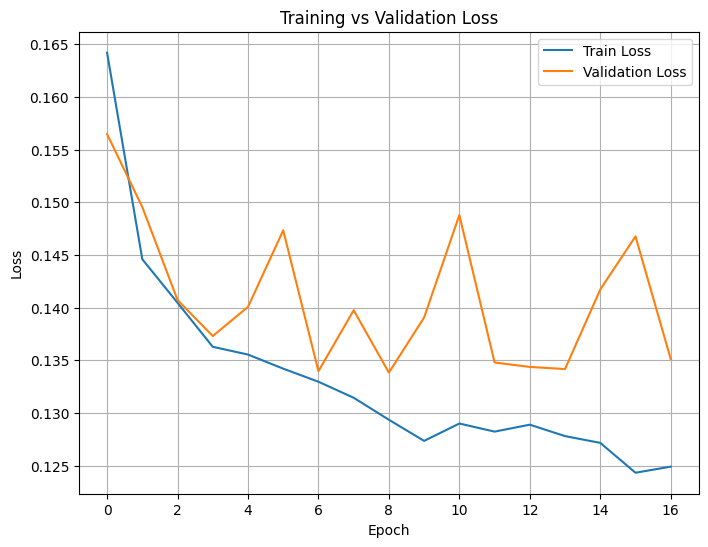

In [47]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
drive.mount('/content/drive', force_remount=True)

save_dir = "/content/drive/MyDrive/Samsung/src/saves"
os.makedirs(save_dir, exist_ok=True)
CKPT_PATH = os.path.join(save_dir, "tinypatchregressor_jianjin008_best.pth")

torch.save(model.state_dict(), CKPT_PATH)
print("Saved:", CKPT_PATH)

Mounted at /content/drive
Saved: /content/drive/MyDrive/Samsung/src/saves/tinypatchregressor_jianjin008_best.pth


# Samsung Inference

In [49]:
zip_file_path = "/content/drive/MyDrive/Samsung_Datasets/dataset.zip"
extract_path = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted"

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: Zip file not found at '{zip_file_path}'")
else:
    print(f"Zip file found at '{zip_file_path}'")
    # Check if the extraction directory exists and is not empty
    if os.path.exists(extract_path) and os.listdir(extract_path):
        print(f"Extraction directory '{extract_path}' already exists and is not empty. Skipping extraction.")
    else:
        # Create the extraction directory if it doesn't exist
        os.makedirs(extract_path, exist_ok=True)
        print(f"Extraction directory '{extract_path}' not found or is empty. Starting extraction...")
        try:
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
        except Exception as e:
            print(f"Error during extraction: {e}")

Zip file found at '/content/drive/MyDrive/Samsung_Datasets/dataset.zip'
Extraction directory '/content/drive/MyDrive/Samsung_Datasets/dataset_extracted' already exists and is not empty. Skipping extraction.


In [50]:
base_folder = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"
subfolders_to_check = ["clean", "new", "ref"]
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff'] # Common image file extensions

for subfolder_name in subfolders_to_check:
    subfolder_path = os.path.join(base_folder, subfolder_name)
    if os.path.exists(subfolder_path) and os.path.isdir(subfolder_path):
        image_count = 0
        for item in os.listdir(subfolder_path):
            if os.path.isfile(os.path.join(subfolder_path, item)):
                # Check if the file has a common image extension (case-insensitive)
                if any(item.lower().endswith(ext) for ext in image_extensions):
                    image_count += 1
        print(f"Number of image files in '{subfolder_name}': {image_count}")
    else:
        print(f"Error: Subfolder '{subfolder_name}' not found or is not a directory at '{subfolder_path}'")

Number of image files in 'clean': 1849
Number of image files in 'new': 1849
Number of image files in 'ref': 1849


In [51]:
# ==== PATHS (Samsung) ====

base_folder = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"  # <- your root
SAMSUNG_ROOT = base_folder

def looks_like_samsung_meta(p):
    try:
        with open(p, "r") as f:
            js = json.load(f)
        rec = js[0] if isinstance(js, list) and js else (js.get("data", [None])[0] if isinstance(js, dict) else None)
        if not rec: return False
        return ("clean_image" in rec) and ("distorted_image" in rec) and ("metadata" in rec)
    except Exception:
        return False

SAMSUNG_TEST_META = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset/test_metadata.json"

# Trained Jianjin008 checkpoint
CKPT_PATH = "/content/drive/MyDrive/Samsung/src/saves/tinypatchregressor_jianjin008_best.pth"

print("SAMSUNG_ROOT     :", SAMSUNG_ROOT)
print("SAMSUNG_TEST_META:", SAMSUNG_TEST_META)
print("CKPT_PATH        :", CKPT_PATH)

SAMSUNG_ROOT     : /content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset
SAMSUNG_TEST_META: /content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset/test_metadata.json
CKPT_PATH        : /content/drive/MyDrive/Samsung/src/saves/tinypatchregressor_jianjin008_best.pth


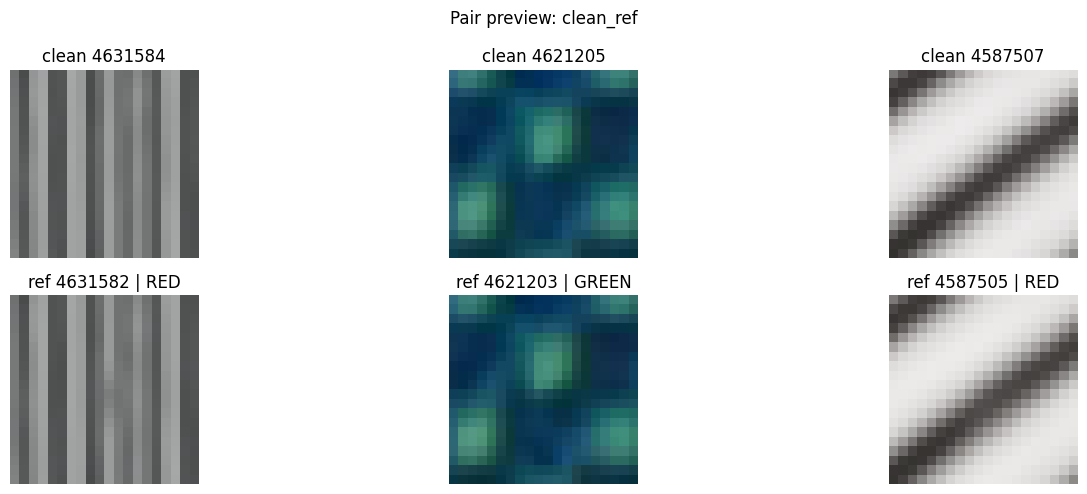

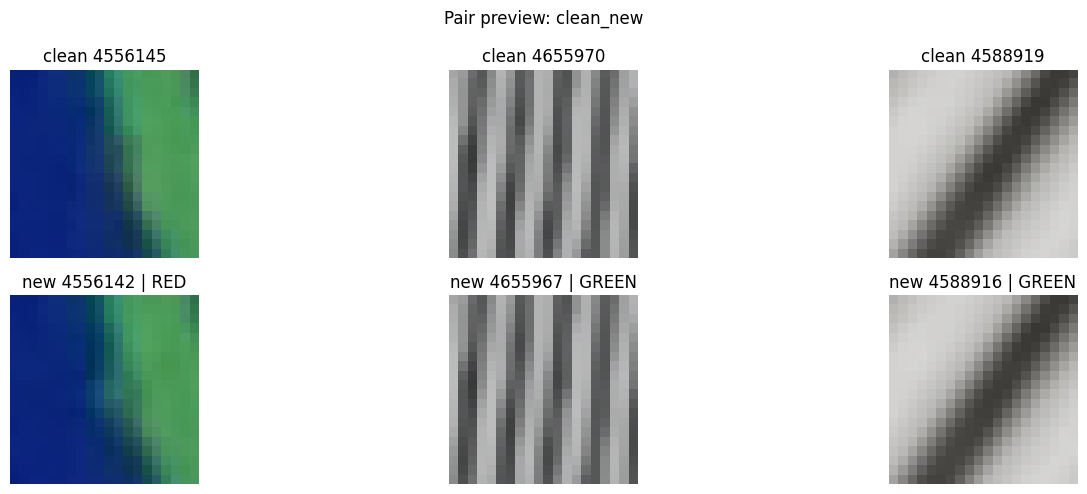

In [52]:
# Pair-aware preview using existing base_folder
base_folder = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"
SAMSUNG_TEST_META = os.path.join(base_folder, "test_metadata.json")
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

def dir_map(d):
    return {os.path.splitext(f)[0]: os.path.join(d, f)
            for f in os.listdir(d)
            if os.path.splitext(f)[1].lower() in image_extensions and os.path.isfile(os.path.join(d,f))}

clean_map = dir_map(os.path.join(base_folder, "clean"))
ref_map   = dir_map(os.path.join(base_folder, "ref"))
new_map   = dir_map(os.path.join(base_folder, "new"))

with open(SAMSUNG_TEST_META, "r") as f:
    rows = json.load(f)

def sample_and_show(pair_type="clean_ref", k=3):
    want = "ref" if pair_type=="clean_ref" else "new"
    subset = [r for r in rows if str(r.get("metadata",{}).get("method","")).lower()==want]
    subset = random.sample(subset, min(k, len(subset)))
    plt.figure(figsize=(5*k, 5))
    for i, r in enumerate(subset, 1):
        clean_id = str(r["clean_image"])
        dist_id  = str(r["distorted_image"])
        label    = str(r.get("metadata",{}).get("color","?")).upper()

        p_clean = clean_map.get(clean_id)
        p_other = (ref_map if want=="ref" else new_map).get(dist_id)
        if not (p_clean and p_other):
            print("Missing:", r.get("unique_sample_id")); continue

        ax1 = plt.subplot(2, k, i);     ax1.imshow(Image.open(p_clean)); ax1.set_title(f"clean {clean_id}"); ax1.axis("off")
        ax2 = plt.subplot(2, k, i+k);   ax2.imshow(Image.open(p_other)); ax2.set_title(f"{want} {dist_id} | {label}"); ax2.axis("off")
    plt.suptitle(f"Pair preview: {pair_type}"); plt.tight_layout(); plt.show()

sample_and_show("clean_ref", k=3)
sample_and_show("clean_new", k=3)

# Loaders + Helpers

In [53]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, precision_recall_fscore_support
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ---------- 9-channel dataset helpers ----------
LBL_MAP = {"GREEN":0, "ORANGE":1, "RED":2}
TO_T = T.ToTensor()              # training used ToTensor only
READ = lambda p: TO_T(Image.open(p).convert("RGB"))
EXTS = {".png",".bmp",".jpg",".jpeg",".tiff"}

def _dir_map(folder: str):
    return {
        os.path.splitext(f)[0]: os.path.join(folder, f)
        for f in os.listdir(folder)
        if os.path.splitext(f)[1].lower() in EXTS and os.path.isfile(os.path.join(folder,f))
    }

class SamsungIDDataset(Dataset):
    """Emits X=[9,H,W]: [clean(3), distorted(3), |clean-distorted|(3)], y in {0,1,2}."""
    def __init__(self, meta_json: str, root: str, pair_type: str, order: str="clean_other"):
        assert pair_type in ("clean_ref","clean_new") and order in ("clean_other","dist_ref")
        rows = json.load(open(meta_json))
        want = "ref" if pair_type=="clean_ref" else "new"
        self.rows = [r for r in rows if str(r["metadata"]["method"]).lower()==want]
        self.clean = _dir_map(os.path.join(root, "clean"))
        self.ref   = _dir_map(os.path.join(root, "ref"))
        self.new   = _dir_map(os.path.join(root, "new"))
        self.order = order

    def __len__(self): return len(self.rows)

    def _resolve(self, mp, fid):
        k = str(fid)
        if k in mp: return mp[k]
        for p in ("","clean_","ref_","new_"):
            if p+k in mp: return mp[p+k]
        raise FileNotFoundError(f"Missing {k}")

    def __getitem__(self, i):
        r = self.rows[i]; m = r["metadata"]; rid = str(r.get("unique_sample_id", i))
        pc = self._resolve(self.clean, r["clean_image"])
        po = self._resolve(self.ref if m["method"].lower()=="ref" else self.new, r["distorted_image"])
        try:
            clean, other = READ(pc), READ(po)   # [3,H,W] each in [0,1]
        except (FileNotFoundError, UnidentifiedImageError) as e:
            raise FileNotFoundError(f"{e}\nclean={pc}\nother={po}\nrec={rid}")
        diff = torch.abs(clean - other)         # [3,H,W]
        x = torch.cat([clean, other, diff], 0)  # -> [9,H,W]
        y = LBL_MAP.get(str(m["color"]).upper(), -1)
        return x, y, rid

In [54]:
# --- Config (kept; tweaked for robustness) ---
BATCH = 128
NUM_WORKERS = 0                 # avoid multiprocessing hangs with Drive/PIL
ORDER = "clean_other"           # [clean, other, |diff|]
APPLY_SIGMOID = False           # checkpoint trained without sigmoid
DO_INVERT = True                # model outputs quality → invert to severity
CALIBRATION_MAX_ITEMS = 20000   # subsample train for faster calibration (None = full)

LABELS = [0, 1, 2]
NAMES  = ['GREEN', 'ORANGE', 'RED']

torch.set_num_threads(1)

def make_loader(meta, typ, bs=BATCH, shuffle=False):
    return DataLoader(
        SamsungIDDataset(meta, SAMSUNG_ROOT, pair_type=typ, order=ORDER),
        batch_size=bs, shuffle=shuffle, num_workers=NUM_WORKERS,
        pin_memory=False, persistent_workers=False, timeout=0
    )

print(">> Building TEST loaders...")
t0 = time.time()
dl_ref = make_loader(SAMSUNG_TEST_META, "clean_ref")
dl_new = make_loader(SAMSUNG_TEST_META, "clean_new")
print(f"   TEST loaders ready in {time.time()-t0:.2f}s | sizes: ref={len(dl_ref.dataset)}, new={len(dl_new.dataset)}")

# --- Model (9 channels) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">> Device: {device}")
model = TinyPatchRegressor(in_channels=9).to(device)

print(">> Loading checkpoint...")
state = torch.load(CKPT_PATH, map_location="cpu")
sd = state["state_dict"] if isinstance(state, dict) and "state_dict" in state else state
missing, unexpected = model.load_state_dict(sd, strict=False)
print(f"   state_dict loaded | missing={len(missing)} unexpected={len(unexpected)}")

# --- Inference helper with progress + safety ---
def run_inference_9ch_verbose(model, loader, device, apply_sigmoid=False, invert=True, label=""):
    model.eval()
    preds, ys, ids = [], [], []
    amp_en = (getattr(device, "type", None) == "cuda")
    total = len(loader)
    with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=amp_en):
        for xb, yb, rid in tqdm(loader, total=total, desc=f"Infer {label}", leave=False):
            xb = xb.to(device).float()
            z = model(xb).squeeze(-1)
            s = torch.sigmoid(z) if apply_sigmoid else z
            s = torch.clamp(s, 0.0, 1.0)
            if invert:
                s = 1.0 - s
            preds.append(s.cpu().numpy())
            ys.append(yb.numpy())
            ids.extend(list(rid))
    if len(preds) == 0:
        return np.array([], dtype=float), np.array([], dtype=int), []
    return np.concatenate(preds), np.concatenate(ys), ids


>> Building TEST loaders...
   TEST loaders ready in 1.82s | sizes: ref=381, new=359
>> Device: cuda
>> Loading checkpoint...
   state_dict loaded | missing=0 unexpected=0


# TEST inference

In [55]:
print(">> Running TEST inference (ref/new)...")
t0 = time.time()
pred_ref, y_ref, _ = run_inference_9ch_verbose(model, dl_ref, device, apply_sigmoid=APPLY_SIGMOID, invert=DO_INVERT, label="TEST-ref")
pred_new, y_new, _ = run_inference_9ch_verbose(model, dl_new, device, apply_sigmoid=APPLY_SIGMOID, invert=DO_INVERT, label="TEST-new")
print(f"   TEST inference done in {time.time()-t0:.2f}s | ref={pred_ref.shape[0]} new={pred_new.shape[0]}")

# =================== Per-split TRAIN calibration ===================
print(">> Building TRAIN loaders for calibration...")
SAMSUNG_TRAIN_META = os.path.join(SAMSUNG_ROOT, "train_metadata.json")
dl_ref_tr = make_loader(SAMSUNG_TRAIN_META, "clean_ref", bs=BATCH, shuffle=False)
dl_new_tr = make_loader(SAMSUNG_TRAIN_META, "clean_new", bs=BATCH, shuffle=False)
print(f"   TRAIN sizes: ref={len(dl_ref_tr.dataset)} new={len(dl_new_tr.dataset)}")

def run_inference_9ch_calib(model, loader, device, max_items=None, label="CAL"):
    """Optional subsampling for faster calibration."""
    model.eval()
    preds, ys = [], []
    seen = 0
    amp_en = (getattr(device, "type", None) == "cuda")
    total = len(loader) if max_items is None else min(len(loader), max(1, int(np.ceil(max_items / loader.batch_size))))
    with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=amp_en):
        for xb, yb, _ in tqdm(loader, total=total, desc=f"Calib {label}", leave=False):
            xb = xb.to(device).float()
            s = model(xb).squeeze(-1)
            if APPLY_SIGMOID: s = torch.sigmoid(s)
            s = torch.clamp(s, 0.0, 1.0)
            if DO_INVERT: s = 1.0 - s
            preds.append(s.cpu().numpy()); ys.append(yb.numpy())
            seen += xb.size(0)
            if max_items is not None and seen >= max_items:
                break
    if len(preds) == 0:
        return np.array([], dtype=float), np.array([], dtype=int)
    return np.concatenate(preds), np.concatenate(ys)

print(">> Running TRAIN inference (for calibration)...")
t0 = time.time()
ref_tr_s, ref_tr_y = run_inference_9ch_calib(model, dl_ref_tr, device, max_items=CALIBRATION_MAX_ITEMS, label="ref")
new_tr_s, new_tr_y = run_inference_9ch_calib(model, dl_new_tr, device, max_items=CALIBRATION_MAX_ITEMS, label="new")
print(f"   TRAIN inference done in {time.time()-t0:.2f}s | used ref={ref_tr_s.shape[0]} new={new_tr_s.shape[0]}")


>> Running TEST inference (ref/new)...


Infer TEST-ref:   0%|          | 0/3 [00:00<?, ?it/s]

Infer TEST-new:   0%|          | 0/3 [00:00<?, ?it/s]

   TEST inference done in 16.91s | ref=381 new=359
>> Building TRAIN loaders for calibration...
   TRAIN sizes: ref=1468 new=1490
>> Running TRAIN inference (for calibration)...


Calib ref:   0%|          | 0/12 [00:00<?, ?it/s]

Calib new:   0%|          | 0/12 [00:00<?, ?it/s]

   TRAIN inference done in 16.02s | used ref=1468 new=1490


# Calibration

In [56]:

def calibrate_bins(scores, labels, lo=None, hi=None, step=0.002):
    """Find (b1<b2) maximizing balanced accuracy on 3 classes."""
    s = np.asarray(scores); y = np.asarray(labels)
    m = (y >= 0); s, y = s[m], y[m]
    if s.size == 0: return 0.30, 0.60, 0.0
    if lo is None or hi is None:
        p10, p90 = np.percentile(s, [10, 90])
        mid = np.median(s); span = max(0.12, float(p90 - p10))
        lo, hi = max(0.0, mid - span/2), min(1.0, mid + span/2)
        if hi - lo < 0.08:
            lo, hi = max(0.0, mid - 0.10), min(1.0, mid + 0.10)
    best = (0.33, 0.66, -1.0)
    for b1 in np.arange(lo, hi - 0.01, step):
        for b2 in np.arange(b1 + 0.01, hi, step):
            pred = np.digitize(s, [b1, b2])
            bacc = balanced_accuracy_score(y, pred)
            if bacc > best[2]:
                best = (float(b1), float(b2), float(bacc))
    return best  # (b1, b2, bacc)

print(">> Calibrating thresholds on TRAIN...")
b1r, b2r, bacc_r = calibrate_bins(ref_tr_s, ref_tr_y)
b1n, b2n, bacc_n = calibrate_bins(new_tr_s, new_tr_y)
print(f"   TRAIN calibration — REF bins=({b1r:.3f},{b2r:.3f})  NEW bins=({b1n:.3f},{b2n:.3f})")

# ---------- Minimal evaluation helpers ----------
def row_percent(cm_counts: np.ndarray) -> np.ndarray:
    rs = cm_counts.sum(axis=1, keepdims=True)
    return np.divide(cm_counts, rs, where=rs != 0, out=np.zeros_like(cm_counts, dtype=float))

def summarize_for_report(name, y_true, scores, b1, b2):
    y_pred   = np.digitize(scores, [b1, b2])
    cm       = confusion_matrix(y_true, y_pred, labels=LABELS)
    acc      = accuracy_score(y_true, y_pred)
    bacc     = balanced_accuracy_score(y_true, y_pred)
    _, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, labels=LABELS, zero_division=0)
    print(f"\n{name}")
    print(f"Acc={acc:.4f} | BAcc={bacc:.4f} | Recall[G,O,R]=[{recall[0]:.3f}, {recall[1]:.3f}, {recall[2]:.3f}]")
    return cm, row_percent(cm)

>> Calibrating thresholds on TRAIN...
   TRAIN calibration — REF bins=(0.448,0.492)  NEW bins=(0.470,0.510)


# Run and Print

>> Evaluating TEST splits...

Samsung TEST (clean, ref) — calibrated
Acc=0.3963 | BAcc=0.3552 | Recall[G,O,R]=[0.099, 0.395, 0.571]


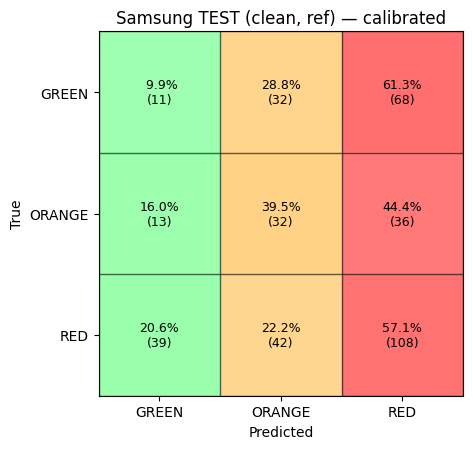


Samsung TEST (clean, new) — calibrated
Acc=0.3370 | BAcc=0.3174 | Recall[G,O,R]=[0.221, 0.326, 0.405]


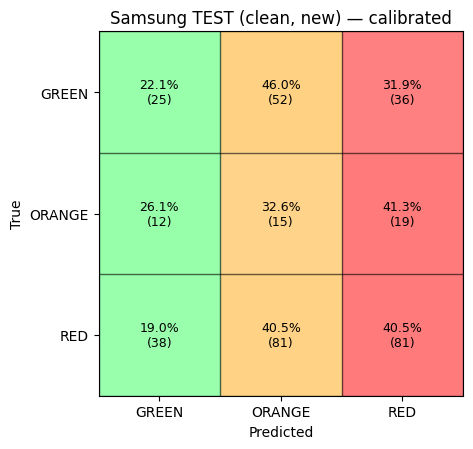

>> Done.


In [57]:

# ---------- Pretty confusion matrix ----------
def plot_cm_color(cm_counts, cm_pct, title=''):
    base = np.array([
        [0.45, 1.00, 0.55],  # GREEN
        [1.00, 0.78, 0.40],  # ORANGE
        [1.00, 0.35, 0.35],  # RED
    ], dtype=float)

    H, W = cm_counts.shape
    rgb = np.zeros((H, W, 3), float)
    fade = 0.35
    for j in range(W):
        tint = fade + (1 - fade) * base[j]
        pct = cm_pct[:, j][:, None]
        rgb[:, j, :] = (1 - pct) * tint + pct * base[j]

    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    ax.imshow(rgb, interpolation='nearest', aspect='equal')
    for x in range(W + 1):
        ax.axvline(x - 0.5, color='black', linewidth=1.0, alpha=0.6)
    for y in range(H + 1):
        ax.axhline(y - 0.5, color='black', linewidth=1.0, alpha=0.6)

    ax.set(title=title, xlabel='Predicted', ylabel='True',
           xticks=range(W), yticks=range(H),
           xticklabels=NAMES, yticklabels=NAMES)

    for i in range(H):
        for j in range(W):
            ax.text(j, i, f"{cm_pct[i, j]*100:4.1f}%\n({cm_counts[i, j]})",
                    ha='center', va='center', fontsize=9, color='black')

    ax.set_xlim(-0.5, W - 0.5); ax.set_ylim(H - 0.5, -0.5)
    plt.tight_layout(); plt.show()

# =================== Apply to TEST (minimal prints + colorful CMs) ===================
print(">> Evaluating TEST splits...")
cm_r, pct_r = summarize_for_report("Samsung TEST (clean, ref) — calibrated", y_ref, pred_ref, b1r, b2r)
plot_cm_color(cm_r, pct_r, "Samsung TEST (clean, ref) — calibrated")

cm_n, pct_n = summarize_for_report("Samsung TEST (clean, new) — calibrated", y_new, pred_new, b1n, b2n)
plot_cm_color(cm_n, pct_n, "Samsung TEST (clean, new) — calibrated")

print(">> Done.")